In [2]:
import os
from os.path import join, exists
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, precision_score

from mnist_A_data_loader import get_mnist_A_loader
from models import *
from utils import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
unique_label = []
for i in range(2):
    for j in range(3):
        for k in range(4):
            for l in range(10):
                unique_label.append([i, j, k, l])
unique_label = np.array(unique_label)

In [5]:
train_loader = get_mnist_A_loader("../data/MNIST_A/train_X/",
                                  "../data/MNIST_A/train_y.npy", unique_label, onehot=False)
test_loader = get_mnist_A_loader("../data/MNIST_A/test_X/",
                                 "../data/MNIST_A/test_y.npy", unique_label, onehot=False, mode="test")
valid_loader = get_mnist_A_loader("./data/MNIST_A/valid_X/",
                                  "../data/MNIST_A/valid_y.npy", unique_label, onehot=False, mode="valid")

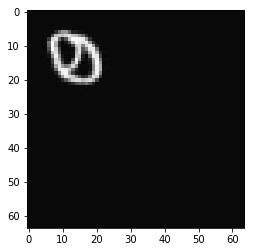

In [7]:
x, y = iter(test_loader).next()
plt.imshow(x[4][0].numpy(), plt.cm.gray)
plt.show()

In [5]:
classifier = MNIST_A_Classifier().to(device)
criterion_ce = nn.CrossEntropyLoss()
criterion_bce = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=5e-4)

# 訓練

In [ ]:
classifier.train()

loss_plot = []
for epoch in range(3):
    for batch_idx, (x, y) in tqdm(enumerate(train_loader)):
        x = x.to(device)
        y = y.to(device)
        y1 = y[:, 0]
        y2 = y[:, 1].long()
        y3 = y[:, 2].long()
        y4 = y[:, 3].long()
        
        optimizer.zero_grad()

        pred_y1, pred_y2, pred_y3, pred_y4 = classifier(x)
        loss1 = criterion_bce(pred_y1, y1)
        loss2 = criterion_ce(pred_y2, y2)
        loss3 = criterion_ce(pred_y3, y3)
        loss4 = criterion_ce(pred_y4, y4)
        loss = loss1 + loss2 + loss3 + loss4
        
        loss.backward()
        optimizer.step()
        
        loss_plot.append(loss.detach())
        
        if (batch_idx+1)%1000==0:
            plt.plot(loss_plot)
            plt.show()

log_dir = "logs"
if not exists(log_dir):
    os.makedirs(log_dir)
torch.save(classifier.state_dict(), join(log_dir, 'MNIST_A_classifier.pkl'))

テスト

In [6]:
log_dir = "./logs"
classifier = MNIST_A_Classifier().to(device)
classifier.load_state_dict(torch.load(join(log_dir, 'MNIST_A_classifier.pkl')))
classifier.eval()

preds = []
ys = []
for batch_idx, (data, label) in tqdm(enumerate(test_loader)):
    with torch.no_grad():
        data = data.to(device)
        pred_y1, pred_y2, pred_y3, pred_y4 = classifier(data)
        pred = torch.cat([pred_y1[:, None], pred_y2, pred_y3, pred_y4], 1)
        ys.extend(label.numpy())
        preds.extend(onehot2label(pred))

preds = np.array(preds)
ys = np.array(ys)

for i, title in enumerate(["size", "rotation", "position", "label"]):
    print(title)
    print(confusion_matrix(ys[:, i], preds[:, i]))
    print(classification_report(ys[:, i], preds[:, i]))
    print(precision_score(ys[:, i], preds[:, i], average='macro'))
    print("")

188it [00:09, 20.58it/s]


size
[[11992     8]
 [    0 12000]]
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00     12000
        1.0       1.00      1.00      1.00     12000

avg / total       1.00      1.00      1.00     24000

0.999666888741

rotation
[[7899   37   64]
 [   0 8000    0]
 [  71   35 7894]]
             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99      8000
        1.0       0.99      1.00      1.00      8000
        2.0       0.99      0.99      0.99      8000

avg / total       0.99      0.99      0.99     24000

0.991376549771

position
[[6000    0    0    0]
 [   0 6000    0    0]
 [   0    0 6000    0]
 [   0    0    0 6000]]
             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      6000
        1.0       1.00      1.00      1.00      6000
        2.0       1.00      1.00      1.00      6000
        3.0       1.00      1.00      1.00      6000

avg / total     